In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb

df = pd.read_csv('standardized_data.csv')
df = df.drop(columns=['ID', 'No_Pation'])
df['CLASS'] = df['CLASS'].map({'N': 0, 'Y': 1, 'P': 2})

X = df.drop(columns=['CLASS'])
y = df['CLASS']

# split 0.8train,0.2test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# nn model
y_train_nn = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_nn = tf.keras.utils.to_categorical(y_test, num_classes=3)

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train_nn, epochs=50, batch_size=32, validation_split=0.2)

# XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 3,
    'seed': 42
}

model_xgb = xgb.train(params, dtrain, num_boost_round=100)

# ensemble
y_pred_nn = model_nn.predict(X_test)
y_pred_xgb = model_xgb.predict(dtest)

# average ensemble
y_pred_ensemble_prob = (y_pred_nn + y_pred_xgb_onehot) / 2
y_pred_ensemble = np.argmax(y_pred_ensemble, axis=1)

# evaluate ensemble model
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"ensemble Accuracy: {accuracy:.4f}")
print("ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6702 - loss: 0.9735 - val_accuracy: 0.8250 - val_loss: 0.7476
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8569 - loss: 0.6517 - val_accuracy: 0.8250 - val_loss: 0.5167
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8627 - loss: 0.4118 - val_accuracy: 0.8250 - val_loss: 0.4207
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8311 - loss: 0.3826 - val_accuracy: 0.8375 - val_loss: 0.3744
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - loss: 0.3168 - val_accuracy: 0.8562 - val_loss: 0.3526
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8618 - loss: 0.2941 - val_accuracy: 0.8500 - val_loss: 0.3369
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8649 - loss: 0.2923 - val_accuracy: 0.8625 - val_loss: 0.3189
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8851 - loss: 0.2595 - val_accuracy: 0.8875 - val_loss

Ensemble Accuracy: 0.9900
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.99      0.99      0.99       173
           2       1.00      1.00      1.00         6

    accuracy                           0.99       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.99      0.99      0.99       200



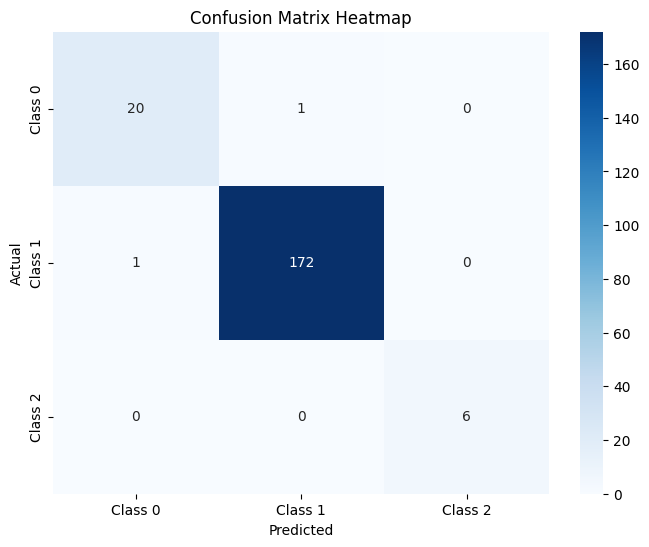

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


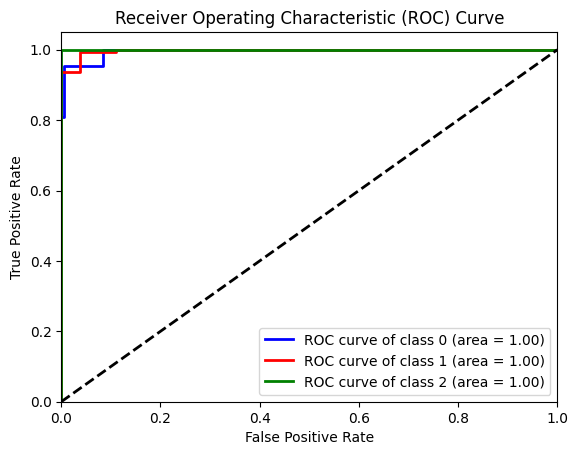

AUC for class 0: 1.00
AUC for class 1: 1.00
AUC for class 2: 1.00


In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Analytical integration model
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {accuracy:.4f}")
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# ROC curve and AUC value
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_pred_ensemble_proba = (model_nn.predict(X_test) + np.eye(3)[model_xgb.predict(dtest).astype(int)]) / 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_ensemble_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the AUC value for each category
for i in range(3):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')